# Injection deomnstration

We are going to start with a ranged injection of $\nu_{\mu}$ charged current events. This takes into account the range that the emerging $\mu^{-}$ can travel and chooses the interaction vertex an appropriate distance away. After that, we will do a volume injection, which selects the interaction vertex in a predefined cylinder near the detector.

In [2]:
import sys
sys.path.append("..")

from prometheus import config

## Everything in Prometheus relies on having a detector.
This then determines the Earth model among other things. We will give the path to one of our prebuilt demonstration detectors. Let's do that straight away.

In [3]:
config["detector"]["geo file"] = "../resources/geofiles/demo_ice.geo"

## We are only going to focus on injecting here, so let's isolate that portion of the config

In [4]:
injection_config = config["injection"]["LeptonInjector"]

import pprint
pprint.pprint(injection_config)

{'inject': True,
 'paths': {'diff xsec': None,
           'earth model location': None,
           'injection file': None,
           'install location': '/opt/LI/install/lib/python3.9/site-packages',
           'lic file': None,
           'total xsec': None,
           'xsec dir': '/Users/jlazar/research/prometheus/resources/cross_section_splines/'},
 'simulation': {'cylinder height': None,
                'cylinder radius': None,
                'earth model': None,
                'endcap length': None,
                'final state 1': 'MuMinus',
                'final state 2': 'Hadrons',
                'injection radius': None,
                'is ranged': None,
                'max azimuth': 360.0,
                'max zenith': 180.0,
                'maximal energy': 1000000.0,
                'min azimuth': 0.0,
                'min zenith': 0.0,
                'minimal energy': 100.0,
                'power law': 1.0}}


## Let's specify our paths.

This can be done in the `'paths'` part of the dictionary.

The `'injection file'` and `'lic file'` control where the output goes. The former is where the data will be put, and the latter stores the `LeptonInjector` configuration will be stored. This is needed for weighting so keep it around if you plan to do that.

All other paths that are `None` will be set to appropriate values internally. Unless you know that you want to use special cross section files, or a special Earth model, we reccomend not playing with the default values.

In [5]:
injection_config["paths"]["injection file"] = "./output/cool_new_injection.h5"
injection_config["paths"]["lic file"] = "./output/cool_new_configuration.lic"

## Now we can fiddle around with the injection parameters.

This is done in the `'simulation'` portion of the config.

We are going to do an all-sky$\nu_{\mu}$ injection. As before, the parameters that are `'None'` will be internally set to reasonable values if left unset. Please see https://arxiv.org/abs/2012.10449 for further explanation of what these do.

In [6]:
# Lots of events
config["run"]["nevents"] = 10_000
# All zenith angle
injection_config["simulation"]["min zenith"] = 0.0
injection_config["simulation"]["max zenith"] = 180.0
# This sets it to numu cc
injection_config["simulation"]["final_1"] = "MuMinus"
injection_config["simulation"]["final_2"] = "Hadrons"

## Now let's inject !

In [7]:
from prometheus import Prometheus

p = Prometheus(config)

In [1]:
p.inject()

NameError: name 'p' is not defined

## Now we have the injection.
Let's load it up and look at what we've got

In [8]:
import h5py as h5
import numpy as np
import os

h5f = h5.File("./output/cool_new_injection.h5", "r")

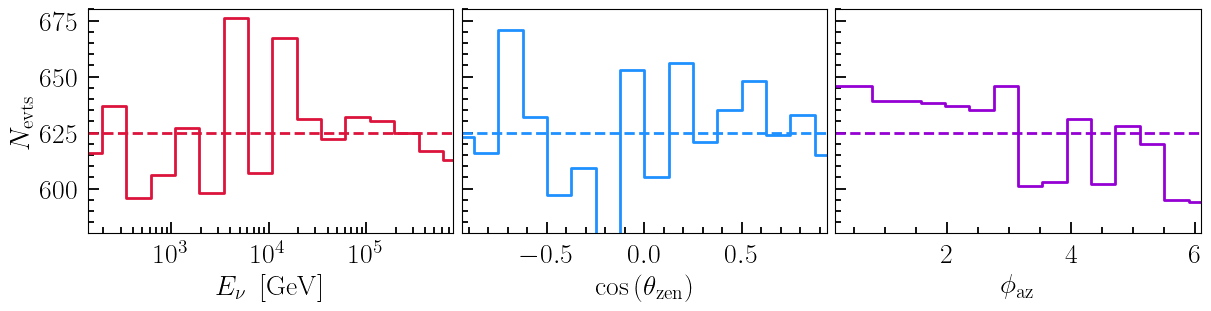

In [9]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.use(os.path.abspath("../paper_plots/paper.mplstyle"))

fig = plt.figure(constrained_layout=True, figsize=(12,3))
gs = GridSpec(1, 3, figure=fig)
axs = [fig.add_subplot(g) for g in gs]

# Histogram the energies in log-spaced bins
e_edges = np.logspace(2, 6, 17)
e_centers = (e_edges[1:] + e_edges[:-1]) / 2
h0, _ = np.histogram(h5f["RangedInjector0"]["properties"]["totalEnergy"], bins=e_edges)

# Histogram the cosine of the zenith
czen_edges = np.linspace(-1, 1, 17)
czen_centers = (czen_edges[1:] + czen_edges[:-1]) / 2
h1, _ = np.histogram(np.cos(h5f["RangedInjector0"]["properties"]["zenith"]), bins=czen_edges)

# Histogram the azimuth
az_edges = np.linspace(0, 2*np.pi, 17)
az_centers = (az_edges[1:] + az_edges[:-1]) / 2
h2, _ = np.histogram(h5f["RangedInjector0"]["properties"]["azimuth"], bins=az_edges)

hs = [h0, h1, h2]
cents = [e_centers, czen_centers, az_centers]
colors = ["crimson", "dodgerblue", "darkviolet"]
xlabels = [r"$E_{\rm{\nu}}~\left[\rm{GeV}\right]$", r"$\cos\left(\theta_{\rm{zen}}\right)$", r"$\phi_{\rm{az}}$"]

for idx, ax in enumerate(axs):
    ax.step(cents[idx], hs[idx], where="mid", c=colors[idx])
    ax.axhline(10_000 / len(e_centers), label="Expectation", c=colors[idx], ls="--")
    ax.set_xlim(cents[idx][0], cents[idx][-1])
    ax.set_ylim(580, 680)
    ax.set_xlabel(xlabels[idx])
    if idx != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel(r"$N_{\rm{evts}}$")

axs[0].semilogx()
plt.show()

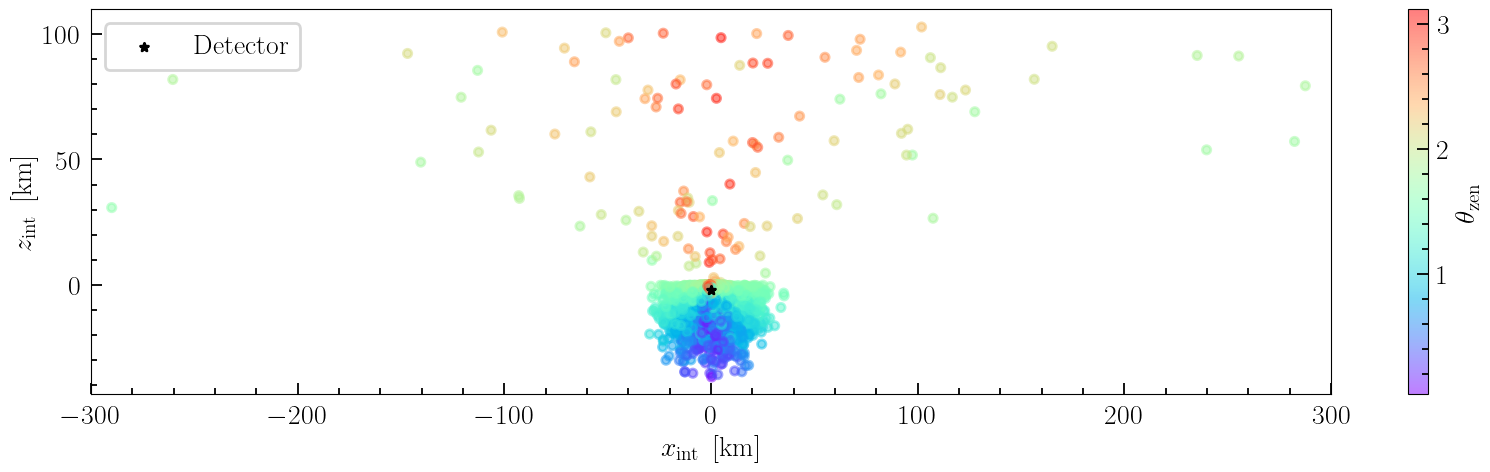

In [10]:
fig, ax = plt.subplots(figsize=(20,5))

sct = ax.scatter(
    h5f["RangedInjector0"]["properties"]["x"] / 1000,
    h5f["RangedInjector0"]["properties"]["z"] / 1000,
    c=h5f["RangedInjector0"]["properties"]["zenith"],
    cmap="rainbow",
    alpha=0.5
)
sct2 = ax.scatter([0], [-2], marker="*", label="Detector", c="k")
ax.set_xlim(-300, 300)
ax.set_xlabel(r"$x_{\rm{int}}~\left[\rm{km}\right]$")
ax.set_ylabel(r"$z_{\rm{int}}~\left[\rm{km}\right]$")
cbar = plt.colorbar(sct, label=r"$\theta_{\rm{zen}}$")
ax.legend(loc=2, fontsize=20)
plt.show()

## Now let's do a volume injection.
This forces the interaction vertex to happen inside a set interaction cylinder. First we will rename some paths.

In [11]:
injection_config["paths"]["injection file"] = "./output/cool_new_volume_injection.h5"
injection_config["paths"]["lic file"] = "./output/cool_new_volume_configuration.lic"

### Now let's turn ranged injection off by hand and set the cylinder parameters.
These cylinder parameters will be set to automatic values if not specified. You can change the seed too, which will modify the enrgy and direction sampling

In [14]:
injection_config["simulation"]["is ranged"] = False
injection_config["simulation"]["cylinder radius"] = 700
injection_config["simulation"]["cylinder height"] = 1000
#config["run"]["random state seed"] = 925

In [15]:
p = Prometheus(config)

### We will make the same plots as we did the last time to show the energy and direction sampling

Note that if you did not change the line which sets the random state seed to something else, you should get identical plots to before.

I am melting.... AHHHHHH!!!!


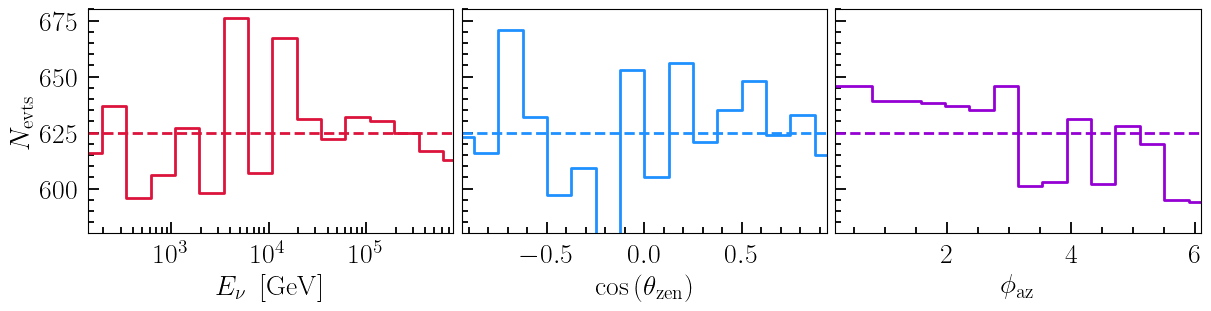

In [16]:
h5f = h5.File("./output/cool_new_volume_injection.h5", "r")

fig = plt.figure(constrained_layout=True, figsize=(12,3))
gs = GridSpec(1, 3, figure=fig)
axs = [fig.add_subplot(g) for g in gs]

# Histogram the energies in log-spaced bins
e_edges = np.logspace(2, 6, 17)
e_centers = (e_edges[1:] + e_edges[:-1]) / 2
h0, _ = np.histogram(h5f["VolumeInjector0"]["properties"]["totalEnergy"], bins=e_edges)

# Histogram the cosine of the zenith
czen_edges = np.linspace(-1, 1, 17)
czen_centers = (czen_edges[1:] + czen_edges[:-1]) / 2
h1, _ = np.histogram(np.cos(h5f["VolumeInjector0"]["properties"]["zenith"]), bins=czen_edges)

# Histogram the azimuth
az_edges = np.linspace(0, 2*np.pi, 17)
az_centers = (az_edges[1:] + az_edges[:-1]) / 2
h2, _ = np.histogram(h5f["VolumeInjector0"]["properties"]["azimuth"], bins=az_edges)

hs = [h0, h1, h2]
cents = [e_centers, czen_centers, az_centers]
colors = ["crimson", "dodgerblue", "darkviolet"]
xlabels = [r"$E_{\rm{\nu}}~\left[\rm{GeV}\right]$", r"$\cos\left(\theta_{\rm{zen}}\right)$", r"$\phi_{\rm{az}}$"]

for idx, ax in enumerate(axs):
    ax.step(cents[idx], hs[idx], where="mid", c=colors[idx])
    ax.axhline(10_000 / len(e_centers), label="Expectation", c=colors[idx], ls="--")
    ax.set_xlim(cents[idx][0], cents[idx][-1])
    ax.set_ylim(580, 680)
    ax.set_xlabel(xlabels[idx])
    if idx != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel(r"$N_{\rm{evts}}$")

axs[0].semilogx()
plt.show()

### And now let's plot the interaction vertex

Note the dramatically different scale.

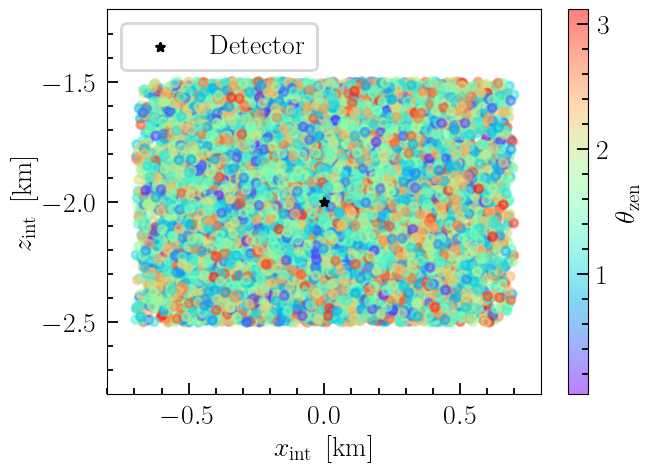

In [18]:
fig, ax = plt.subplots(figsize=(7,5))

sct = ax.scatter(
    h5f["VolumeInjector0"]["properties"]["x"] / 1000,
    h5f["VolumeInjector0"]["properties"]["z"] / 1000,
    c=h5f["VolumeInjector0"]["properties"]["zenith"],
    cmap="rainbow",
    alpha=0.5
)
sct2 = ax.scatter([0], [-2], marker="*", label="Detector", c="k")
ax.set_xlim(-0.8, 0.8)
ax.set_ylim(-2.8, -1.2)
ax.set_xlabel(r"$x_{\rm{int}}~\left[\rm{km}\right]$")
ax.set_ylabel(r"$z_{\rm{int}}~\left[\rm{km}\right]$")
cbar = plt.colorbar(sct, label=r"$\theta_{\rm{zen}}$")
ax.legend(loc=2, fontsize=20)
plt.show()